<a href="https://colab.research.google.com/github/gwfbrave297-hash/labo2025v/blob/main/Predicci%C3%B3nSeriedeTiempoLSTM-161225.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ejemplo Completo de LSTM para Predicción de Series de Tiempo

Este ejemplo utiliza una onda sinusoidal simple como serie de tiempo artificial para facilitar la comprensión de los resultados.
1. Preparación y Generación de Datos

Primero, importamos las librerías necesarias y creamos una función para generar la serie de tiempo y prepararla en el formato que necesita la LSTM (secuencias de entrada/salida).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# --- 1. Generación de la Serie de Tiempo Artificial (Onda Senoidal) ---
def generate_time_series(periods=500):
    """Genera una serie de tiempo artificial (sinusoidal + ruido)."""
    time = np.arange(periods)
    series = np.sin(0.1 * time) + np.random.normal(0, 0.1, periods)
    return series.astype(np.float32).reshape(-1, 1)

# --- 2. Función de Preprocesamiento: Crear Secuencias ---
def create_sequences(data, time_steps):
    """
    Convierte la serie de tiempo en secuencias de entrada (X) y salidas (y).

    X: [t, t+1, ..., t + time_steps - 1]
    y: [t + time_steps]
    """
    X, y = [], []
    for i in range(len(data) - time_steps):
        # Secuencia de entrada (la ventana)
        X.append(data[i:(i + time_steps), 0])
        # Valor a predecir (justo después de la ventana)
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# --- CONFIGURACIÓN PRINCIPAL ---
TIME_STEPS = 10  # Longitud de la secuencia de entrada (la 'ventana' de tiempo)
N_FEATURES = 1   # Número de características (solo el valor en este caso)

# Generar y escalar los datos
raw_series = generate_time_series(periods=1000)

# Escalado Min-Max (MUY importante para LSTMs)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(raw_series)

# Crear secuencias (X) y salidas (y)
X, y = create_sequences(scaled_series, TIME_STEPS)

# Redimensionar X para que Keras lo acepte: [muestras, time_steps, n_features]
X = X.reshape(X.shape[0], X.shape[1], N_FEATURES)

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

2. Definición y Entrenamiento del Modelo

Definiremos una función para construir el modelo y luego la usaremos para probar diferentes configuraciones.

In [2]:
# --- 3. Función para Construir y Entrenar el Modelo LSTM ---
def build_and_train_model(X_train, y_train, units_config, epochs=50, batch_size=32, verbose=0):
    """
    Construye y entrena un modelo LSTM con una configuración de capas dada.

    Args:
        units_config (list): Lista de enteros, donde cada entero es la
                             cantidad de neuronas en una capa LSTM.
    """
    model = Sequential()

    # Agregar las capas LSTM (usamos 'return_sequences=True' para todas las capas
    # excepto la última capa LSTM, si hay más de una)
    for i, units in enumerate(units_config):
        is_last_lstm = (i == len(units_config) - 1)
        model.add(
            LSTM(units=units,
                 input_shape=(TIME_STEPS, N_FEATURES),
                 return_sequences=not is_last_lstm)
        )

    # Capa de salida (Dense)
    model.add(Dense(1))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='mse')

    # Entrenar el modelo
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.1,
                        verbose=verbose)

    # Devolver el modelo entrenado y su historial
    return model, history.history['val_loss'][-1]


# --- 4. Pruebas de Configuración ---

print("### Iniciando Pruebas de Configuración de LSTM ###")
results = {}

# Configuración 1: LSTM Simple (1 capa)
config_1 = [50]
print(f"-> Probando Configuración 1 (Capas: {config_1})")
model_1, loss_1 = build_and_train_model(X_train, y_train, config_1)
results['Config 1'] = (model_1, loss_1)
print(f"   Pérdida de Validación: {loss_1:.6f}\n")

# Configuración 2: LSTM con más neuronas (1 capa, 100 neuronas)
config_2 = [100]
print(f"-> Probando Configuración 2 (Capas: {config_2})")
model_2, loss_2 = build_and_train_model(X_train, y_train, config_2)
results['Config 2'] = (model_2, loss_2)
print(f"   Pérdida de Validación: {loss_2:.6f}\n")

# Configuración 3: LSTM Apilada (2 capas)
config_3 = [50, 50]
print(f"-> Probando Configuración 3 (Capas: {config_3})")
model_3, loss_3 = build_and_train_model(X_train, y_train, config_3)
results['Config 3'] = (model_3, loss_3)
print(f"   Pérdida de Validación: {loss_3:.6f}\n")

# Mostrar resumen de resultados
print("\n--- Resumen de Resultados ---")
for name, (_, loss) in results.items():
    print(f"{name}: Pérdida (MSE) = {loss:.6f}")

### Iniciando Pruebas de Configuración de LSTM ###
-> Probando Configuración 1 (Capas: [50])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   Pérdida de Validación: 0.002594

-> Probando Configuración 2 (Capas: [100])
   Pérdida de Validación: 0.002679

-> Probando Configuración 3 (Capas: [50, 50])
   Pérdida de Validación: 0.002518


--- Resumen de Resultados ---
Config 1: Pérdida (MSE) = 0.002594
Config 2: Pérdida (MSE) = 0.002679
Config 3: Pérdida (MSE) = 0.002518


3. Evaluación y Visualización

Finalmente, evaluamos el modelo con mejor rendimiento (en este caso, la Configuración 3) y visualizamos los resultados en el conjunto de prueba.

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


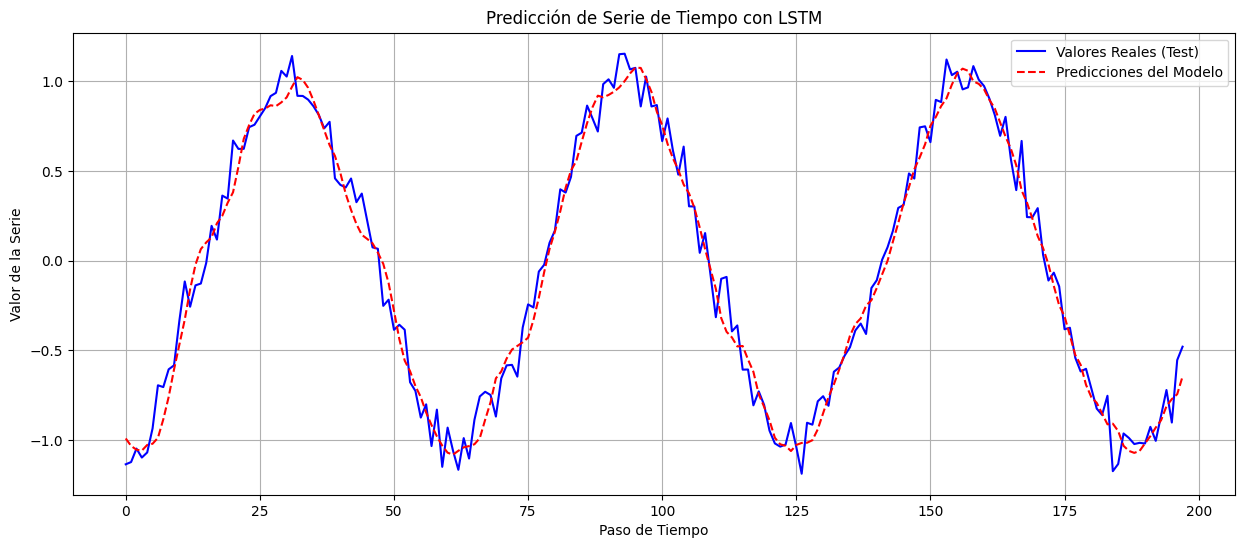

In [3]:
# --- 5. Evaluación del Mejor Modelo (Asumiendo que es la Configuración 3) ---
best_model = model_3 # Puede cambiar según los resultados de la prueba

# Realizar predicciones
predictions_scaled = best_model.predict(X_test)

# Invertir el escalado para obtener los valores reales
predictions = scaler.inverse_transform(predictions_scaled)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- 6. Visualización de Resultados ---
plt.figure(figsize=(15, 6))
plot_range = range(len(y_test_original))

# Valores Reales (conjunto de prueba)
plt.plot(plot_range, y_test_original, label='Valores Reales (Test)', color='blue')

# Predicciones
plt.plot(plot_range, predictions, label='Predicciones del Modelo', color='red', linestyle='--')

plt.title('Predicción de Serie de Tiempo con LSTM')
plt.xlabel('Paso de Tiempo')
plt.ylabel('Valor de la Serie')
plt.legend()
plt.grid(True)
plt.show()

Análisis de las Configuraciones

En el ejemplo anterior, probamos tres arquitecturas clave:

  config_1 = [50]: Una sola capa LSTM con 50 unidades. Es el modelo más simple y rápido de entrenar.

  config_2 = [100]: Una sola capa LSTM con 100 unidades. Al aumentar el número de unidades, el modelo tiene más capacidad para aprender patrones complejos, pero también aumenta el riesgo de overfitting.

  config_3 = [50, 50]: Dos capas LSTM apiladas (50 unidades cada una). Los modelos apilados a menudo son más potentes. La clave aquí es el uso de return_sequences=True en la primera capa, que asegura que la salida sea una secuencia completa (necesaria para la entrada de la siguiente capa LSTM). La última capa LSTM debe tener return_sequences=False (por defecto) para producir un solo vector.

La comparación de las pérdidas de validación te indicará qué configuración se desempeñó mejor para esta serie de tiempo específica. Para series de tiempo reales, la mejor configuración a menudo se encuentra experimentando con:

  Número de Capas LSTM: ¿1, 2 o 3? (Apiladas).

   Neuronas por Capa: ¿32, 50, 64, 100, 128?

  TIME_STEPS (Longitud de Secuencia): ¿Cuántos pasos de tiempo pasados necesita el modelo para predecir el futuro?